# A mini-tutorial for Recognition Parametrized Factor Analysis (RP-FA)

Hugo. 2024-04-08

**TL;DR** This notebook contains implementation examples of RP-FA, a few observations regarding latent identifiability and some useful tricks for fitting a model. 

## 1. Notations, Methods and Tricks

### 1.1 Model

Let $\mathcal{X} = \{ \mathsf{x_j}\}_{j=1}^J$ be one observation comprising $J$ conditionally indendent factors, the RPM writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

where, given a set of observations $\{ \mathcal{X}^{(n)} \}_{n=1}^N$:

- $\mathsf{p_{0,j}}(\mathsf{x_{j}}) = \frac{1}{N} \sum_n \delta(\mathsf{x_{j}} - \mathsf{x_{j}}^{(n)})$

- $\mathsf{F_{\theta j}}(\mathcal{Z}) = \frac{1}{N} \sum_n \mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}^{(n)}})$

We assume that each recognition factor $\mathsf{f_{\theta j}}( \cdot | \mathsf{x_{j}^{(n)}})$ is defined by natural parameters $\eta_j( \mathsf{x_{j}}^{(n)}) = \eta_j^{(n)}$ and parametrised by neural networks. 


### 1.2 Free Energy and Inner Variational Bound (or ELBO and ELLBO)

The Free Energy (or ELBO) is a lower bound to the log-likelihood that we will use forlearning and inference. Given variational distributions $q^{(n)}$ (defined by natural parameter $\eta_q^{(n)}$) it writes:

$$\mathcal{F} = - \sum_n \mathsf{KL}(q^{(n)} || \mathsf{p_{\theta_z}}) + \sum_{jn} \log \mathsf{p_{0,j}}(x_{j}^{(n)}) + \sum_{jn} \bigg \langle \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \bigg\rangle_{q^{(n)}}$$ 

When the recognition and the variational are multivariate normal distribution, $\mathcal{F}$ is not tractable. We therefore rely on an inner variational lower bound (or ELLBO):

$$\tilde {\mathcal{F}} = - \sum_n \mathsf{KL}(q^{(n)} || \mathsf{p_{\theta_z}}) - \sum_{jn} \mathsf{KL}(q^{(n)} || \mathsf{\hat{f}_{\theta j}}( \cdot | \mathsf{x_{j}^{(n)}})) + \sum_{nj} \log \Gamma_j^n$$ 



where:
- $\mathsf{\hat{f}_{\theta j}}( \cdot | \mathsf{x_{j}^{(n)}})$ is defined by natural parameter $\eta_j( \mathsf{x_{j}}^{(n)}) + \tilde{\eta}_j^{(n)}$

- $\Gamma_j^n = \frac{\exp(s_j^{n,n})}{\sum_m \exp(s_j^{m,n})}$

- $s_j^{m,n} = - \frac{1}{4} \eta_{j,1}^{(m) \top} \left[  \left(\eta_{j,2}^{(n)} + \tilde{\eta}_{j, 2}^{(n)} \right)^{-1} + \left(\eta_{j,2}^{(n)} \right)^{-1} \right] \eta_{j,1}^{(m)} + \frac{1}{2} \eta_{j,1}^{(m) \top}  \left(\eta_{j,2}^{(n)} + \tilde{\eta}_{j, 2}^{(n)} \right)^{-1} \tilde{\eta}_{j,1}^{(n)}$

**Note:** this parametrisation slightly differs from the [original paper](https://arxiv.org/abs/2209.05661) but, with no loss of generality, it ensures validity of the model provided that all precision parameters are valid (to this extent, one typically parametrise their Cholesky decomposition, possibly with some jitter. Also note that using good estimation of logsumexp functions is critical for stability).

### 1.3 Learning and inference

- A convenient yet principled assumption is to set all 2nd natural parameters independent of the sample $n$. For example, for all $n= 1..N$, $\eta_{j,2}^{(n)} = \eta_{j,2}$. Not only does it follow from related conjugacy results, but it significantly speeds up and stabilize learning.

- Using fully flexible auxiliary parameters $\tilde{\eta}$ greatly complexifies the fitting procedure and increases memory requirements. Instead, we recall that the ELLBO is tight when $\mathsf{F_{\theta j}} \times \tilde{f}_j^{(n)} \approx q^{(n)}$. Of course, we cannot guarantee equality in the finite sample case since $\mathsf{F_{\theta j}}$ is a mixture. But we can either approximate it with (i) the prior or (ii) a moment-matched approximation. The former is more efficient, but the latter allows to tailor the approximation to each factor $j$.

- In the latter case, we obtain $\tilde{\eta}_j^{(n)} = \eta_q^{(n)} - \eta_{\mathsf{Fj}}$ where 

$$\eta_{\mathsf{Fj}, 1} = \left( I + \mathbb{V}(\eta_{j, 1}) \left(- \frac{1}{2} \eta_{j,2}^{-1} \right) \right)^{-1} \mathbb{E}(\eta_{j, 1}) \text{ and } \eta_{\mathsf{Fj}, 2} = \left( I + \mathbb{V}(\eta_{j, 1}) \left(- \frac{1}{2} \eta_{j,2}^{-1} \right) \right)^{-1} \eta_{j, 2}$$

(note: here expectation and variances are taken over samples $n$)



- If the prior $\mathsf{p_{\theta_z}}$ is also a multivariate normal distribution defined by $\eta_0$, the update for $q$ is closed form and obeys:

$$\eta_q^{(n)} = \frac{1}{J+1} \left( \eta_0 + \sum_{j=1}^J \eta_j^{(n)} + \tilde{\eta}_j^{(n)}   \right)$$

- A more general scenario that I am currently testing uses a Mixture of Gaussians. $\mathsf{p_{\theta_z}} = \sum_u \omega_u \mathsf{p_u}$ where each $\mathsf{p_u}$ is a Multivariate Gaussians with natural parameter $\eta_u$. In this case, we can use another variational approximation to the KL divergence between the prior and the variational distribution. It yiels the ELLLBO (or Evidence Lower Lower Lower Bound): 

$$\tilde{\tilde{\mathcal{F}}} = \sum_n \log \beta^{(n)} - \sum_{jn} \mathsf{KL}(q^{(n)} || \mathsf{\hat{f}_{\theta j}}( \cdot | \mathsf{x_{j}^{(n)}})) + \sum_{nj} \log \Gamma_j^n$$ 

where the last two terms are unchanged and $\beta^{(n)} = \sum_u \omega_u e^{- \mathsf{KL}(q^{(n)} || \mathsf{p_u})}$. This prior seems appropriate when the underlying prior is multimodal, or badly described by a Gaussian distribution. For initialization, we try to space the centroids evenly on a unit hypersphere to avoid them collapsing early. **Note**: One might consider using a similar bound on Mixture Parametrised Recognition factors.

- When the variational is not closed form, one solution is to paramametrize it with a fusion neural network that takes each observations $\{ x_j \}$ factors as an input. Yet, this seems unecessarily complicated. Although the update for $q$ is not closed form anymore, deriving the ELLLBO with respect to $\eta_q^{n}$ shows that it should only depend on the recognition factors embedding. We therefore propose to parametrize the variational with a simple MultiLayer Perceptron (MLP) whose input is the concatenation of the factors natural parameters (see figure below). Finally, as initialization empiraically showed to be key, we pretrain the variational recognition network to output the average (or similar) natural parameter of $J$.

<img src="figures/tmp.png" style="height:300px">

## 2. Results: Identifiability of the covariance

Let us start with a very simple generative model: a (possibly mixture) factor analysis. Here, we assume that: 

$$\mathsf{p}(\mathsf{z}) = \sum_{u=1}^U \omega_u \mathsf{p}_u(\mathsf{z})$$

where each $\mathsf{p}_u$ is a Gaussian distribution. Moreover, for $j = 1.. J$:

$$\mathsf{p}(\mathsf{x_j} | \mathsf{z}) = \mathcal{N} \left( A_j \mathsf{z}, \Sigma_j \right)$$

For plotting purposes, we will assume that $\mathsf{z}$ is one dimensional (note that the observations are multidimensional). The code below generate such a dataset.

In [1]:
# Fit params

import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss


import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F

# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

def generate_1D_mixture_factor_analysis(
    num_observations, 
    dim_observations,
    num_factors,
    cluster_num = 1,
    cluster_scattering = 10,
    amplitude_cluster = 8,  
    variance_scales = [1],
):
    
    # Stick to 1D for now
    dim_latent_true = 1
    
    # Position of the centroids
    centroids = cluster_scattering * torch.linspace(-1, 1, cluster_num, device=device).unsqueeze(-1)

    # Sample cluster
    centroids_sample = centroids[np.random.choice(range(cluster_num), num_observations, replace=True)]
    
    # Add some gaussian noise around cluster mean
    zlatent = torch.randn(num_observations, dim_latent_true, device=device) +  centroids_sample

    # E(x) = Az
    link_factors = torch.rand(num_factors, dim_observations, dim_latent_true, device=device)
    
    # Variances
    vari_factors = 0.1 * torch.eye(dim_observations, device=device).unsqueeze(0).repeat(num_factors, 1, 1)
    
    # Scale Variances
    for JJ in range(num_factors):
        vari_factors[JJ] *= variance_scales[JJ]
    
    # Sample each Factor Noise
    noise = torch.sqrt(vari_factors.diagonal(dim1=-1,dim2=-2).unsqueeze(1)) * torch.randn(num_factors, num_observations, dim_observations, device=device)

    # Build Observations
    observations = torch.matmul(link_factors.unsqueeze(1), zlatent.unsqueeze(0).unsqueeze(-1)).squeeze(-1) + noise
    
    # RPM Compatible Observations    
    observations = [obsi for obsi in observations]
    
    return observations, zlatent

In [2]:
# imput: rpm, observations
def get_results(rpm, observations):
    # Get Variational and Recognition Distributions on CPU
    qdist, fdist = rpm.get_posteriors(observations)
    qmean = qdist.mean_covariance()[0].to("cpu")
    fmean = [fi.to("cpu") for fi in fdist.mean_covariance()[0]]
    qvar = qdist.mean_covariance()[1][0].to("cpu")
    fvar = [fi[0].to("cpu") for fi in fdist.mean_covariance()[1]]

    # Get Prior Distribution on CPU
    with torch.no_grad():
        natural1_prior = rpm.prior.natural1.cpu()
        natural2_prior = rpm.prior.natural2().cpu()
        mixturew_prior = rpm.prior.responsabilities().cpu()
        natural1_factors, natural2_factors = [fi.cpu() for fi in rpm.forwarded_factors]

    # Prior Components Distributions
    mixture_distributions = flexible_multivariate_normal.FlexibleMultivariateNormal(
        natural1_prior,
        natural2_prior,
        init_cholesky=False,
        init_natural=True,
        store_suff_stat_mean=True,
    )
    prior_mean = mixture_distributions.mean_covariance()[0]

    # Recognition Distributions
    natural2_factors = natural2_factors.unsqueeze(1).repeat(1, natural1_factors.shape[1], 1, 1)
    factors_distributions =flexible_multivariate_normal.FlexibleMultivariateNormal(
        natural1_factors,
        natural2_factors,
        init_cholesky=False,
        init_natural=True,
        store_suff_stat_mean=True,
    )
    
    # Store
    plot_mean = [qmean, *fmean]
    plot_var = [qvar, *fvar]
    plot_title = [r'$q(Z)$', *[r'$f_ ' + str(ii) + '(Z | x_ ' + str(ii) + ')$' for ii,_ in enumerate(fmean) ]]
    
        
    # Support to evaluate pdf
    zmin = 1.5 * np.min([ii.min() for ii in plot_mean])
    zmax = 1.5 * np.max([ii.max() for ii in plot_mean])
    zz = torch.linspace(zmin, zmax, 1000).unsqueeze(-1).unsqueeze(-1)

    # Mixture pdf
    pdf_mixture_prior_all = torch.exp(mixture_distributions.log_prob(zz))
    pdf_mixture_prior = (pdf_mixture_prior_all * mixturew_prior.unsqueeze(0)).sum(-1)
    pdf_mixture_factors = torch.exp(factors_distributions.log_prob(zz.unsqueeze(1))).mean(-1)
    pdf_mixture_prior = pdf_mixture_prior.numpy()
    pdf_mixture_factors = pdf_mixture_factors.numpy()
    pdf_mixture_prior_all = pdf_mixture_prior_all.numpy()
    
    prior_distribution = {
        'prior_all': pdf_mixture_prior_all,
        'prior': pdf_mixture_prior,
        'mean': prior_mean,
        'range': zz.squeeze(),
    }
    
    recognition_distributions = {
        'variational':{
            'mean':qmean,
            'variance':qvar,
            'name':r'$q(Z)$',
            'mixture_pdf': None,
            'range': zz.squeeze(),
        }
    }
    
    for ii,_ in enumerate(fmean):
        recognition_distributions['factor'+str(ii)] = {
            'mean':fmean[ii],
            'variance':fvar[ii],
            'name': r'$f_ ' + str(ii) + '(Z | x_ ' + str(ii) + ')$',
            'mixture_pdf': pdf_mixture_factors[..., ii],
            'range': zz.squeeze(),
        }
    
    return recognition_distributions, prior_distribution


def gdensity1D(mean, sigma2):
    def func(z):
        return torch.exp( - 0.5 * (z- mean) ** 2 / sigma2) / torch.sqrt(2 * torch.tensor(np.pi))
    return func

def plot_results(results_dict, true_latent):
    
    # Figure Size
    heigh = 2
    width = plot_num
    plt.figure(figsize=(width * 5, heigh * 5))

    # Loop over distribution
    for ii, key in enumerate(recognition_distributions.keys()):

        # Recognition Results
        res = recognition_distributions[key]
        mean = res['mean'].numpy()
        vari = res['variance']
        name = res['name']
        mixture = res['mixture_pdf']
        zrange = res['range']

        # Ztrue Vs Zfit
        plt.subplot(heigh, width, ii + 1)
        plt.scatter(mean, true_latent, c='k')

        # Plot Prior centroids as vertical line
        for pmean in prior_distribution['mean'].numpy():
            plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')

        # Labels
        plt.ylabel('True Z')
        plt.xlabel('argmax ' + name)
        plt.xlim([zrange.min(), zrange.max()])
        plt.title(name)
        plt.grid()

        # Prior and Mixture pdfs
        plt.subplot(heigh, width, ii + 1 + width)

        # Plot Prior centroids as vertical line
        for pmean, ppdf in zip(prior_distribution['mean'].numpy(), prior_distribution['prior_all'].transpose(-1, -2)):
            plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
            plt.plot(zrange, ppdf, lw =1, c='gray')
        plt.plot(zrange, prior_distribution['prior'], lw =1, c='k', label = r'$p_0(Z)$ Prior')
        if mixture is not None:
            plt.plot(zrange, mixture, label= r'$F_' + name[-3] + '(Z)$', lw=3)

        # Labels
        plt.xlim([zrange.min(), zrange.max()])    
        plt.xlabel('Z')
        plt.grid()
        plt.legend()

### 2.1 Gaussina prior, 2 Factors: Impossible

Let us start simple with $U = 1$ (the prior is normal distributed). We will assume that recognition is linear and that $\Sigma_2 >> \Sigma_1$. In other word, one factor is much noiser than the other.

In [3]:
# Random seeds
torch.manual_seed(1) 
np.random.seed(1)    

# Fit params
num_factors =  2
dim_latent_true = 1
dim_observations = 10
num_observations = 200
variance_scales = [1, 10]

observations, zlatent = generate_1D_mixture_factor_analysis(
    num_observations, 
    dim_observations,
    num_factors,
    cluster_num = 1,
    cluster_scattering = 10,
    amplitude_cluster = 8,  
    variance_scales = variance_scales,
)

factors_params = {
    'dim_hidden': [[], []],
    'non_linearity': [torch.nn.Identity(), torch.nn.Identity()],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
}

prior_params = {
    'num_centroids': 1,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=0.0, weight_decay=0.0),
}

fit_params = {
    'num_epoch': 20000,
    'dim_latent': 1,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

rpm.fit(observations)


RPM on GPU Observations on cuda:0
Epoch 2000/20000 Loss: 1.010061e+01
Epoch 4000/20000 Loss: 9.988593e+00
Epoch 6000/20000 Loss: 9.940148e+00
Epoch 20000/20000 Loss: 9.905646e+00


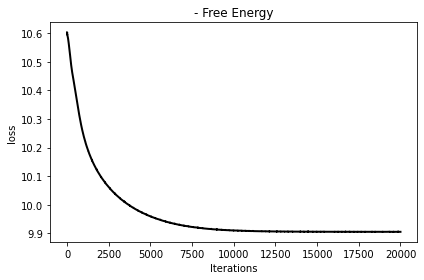

In [4]:
plot_loss(rpm, offset=0)

In [6]:
import flexible_multivariate_normal

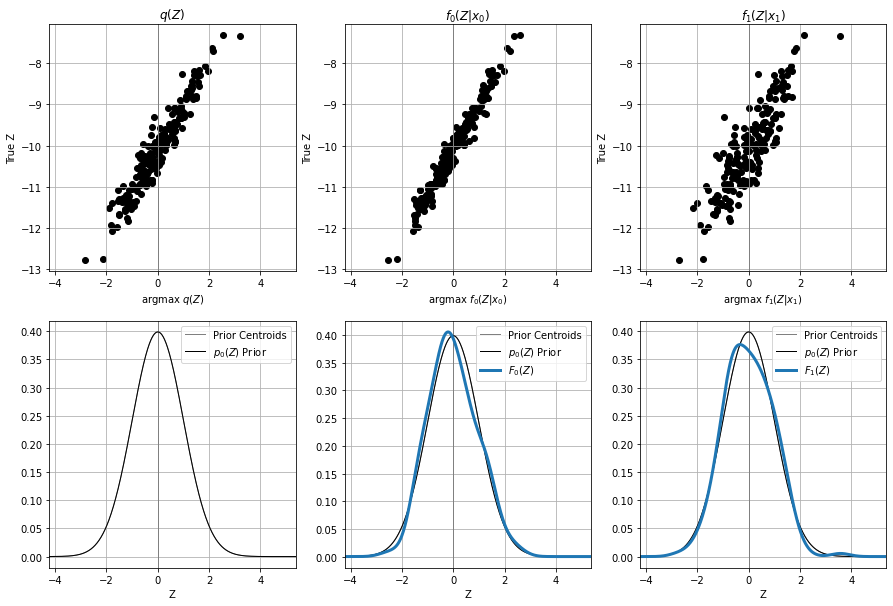

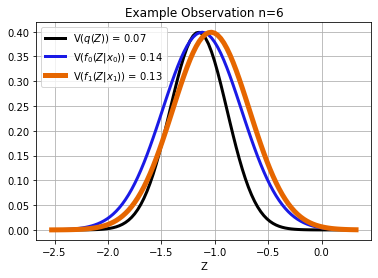

In [7]:
# Move the true Latent To CPU
true_latent = zlatent.to("cpu").numpy()

# Get fit results
recognition_distributions, prior_distribution = get_results(rpm, observations)
plot_num = len(recognition_distributions.keys())


# Figure Size
heigh = 2
width = plot_num
plt.figure(figsize=(width * 5, heigh * 5))

# Loop over distribution
for ii, key in enumerate(recognition_distributions.keys()):
    
    # Recognition Results
    res = recognition_distributions[key]
    mean = res['mean'].numpy()
    vari = res['variance']
    name = res['name']
    mixture = res['mixture_pdf']
    zrange = res['range']
    
    # Ztrue Vs Zfit
    plt.subplot(heigh, width, ii + 1)
    plt.scatter(mean, true_latent, c='k')
    
    # Plot Prior centroids as vertical line
    for pmean in prior_distribution['mean'].numpy():
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
    
    # Labels
    plt.ylabel('True Z')
    plt.xlabel('argmax ' + name)
    plt.xlim([zrange.min(), zrange.max()])
    plt.title(name)
    plt.grid()
    
    # Prior and Mixture pdfs
    plt.subplot(heigh, width, ii + 1 + width)
    
    # Plot Prior centroids as vertical line
    for pmean, ppdf in zip(prior_distribution['mean'].numpy(), prior_distribution['prior_all'].transpose(-1, -2)):
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
        plt.plot(zrange, ppdf, lw =1, c='gray')
    plt.plot(zrange, prior_distribution['prior'], lw =1, c='k', label = r'$p_0(Z)$ Prior')
    if mixture is not None:
        plt.plot(zrange, mixture, label= r'$F_' + name[-3] + '(Z)$', lw=3)
        
    # Labels
    plt.xlim([zrange.min(), zrange.max()])    
    plt.xlabel('Z')
    plt.grid()
    plt.legend()
    
example_observation = 6

means = [
    recognition_distributions[key]['mean'][example_observation]
    for key in recognition_distributions.keys()
]

vari = [
    recognition_distributions[key]['variance']
    for key in recognition_distributions.keys()
]


z0 = torch.mean(torch.tensor(means))
zdelta = 20 * torch.tensor(vari).min()
zrange = torch.linspace(z0 - zdelta, z0 + zdelta, 100)

densities = [
    gdensity1D(imean, ivari)(zrange).squeeze()
    for imean, ivari in zip(means, vari)
]

titles = [
    recognition_distributions[key]['name'] 
    for key in recognition_distributions.keys()
]

colors = [ [0.1, 0.1, 0.9] for _ in densities]
colors[0] = [0.0, 0.0, 0.0]
colors[2] = [0.9, 0.4, 0.0]

linewidths = [ 3 for _ in densities]
linewidths[2] = 5


plt.figure()
for ii, density in enumerate(densities):

    plt.plot(
        zrange, 
        density,
        label = 'V(' + titles[ii] + ') = ' + str(np.round(vari[ii], 2).numpy().squeeze()),
        c = colors[ii],
        lw = linewidths[ii],
    )

plt.title('Example Observation n=' + str(example_observation))
plt.xlabel('Z')
plt.grid()
plt.legend()


**Figure 1**:  **Top** Predicted Vs Fitted Latent. **Middle** Probability Density Functions of the prior and the Recognition Factors Mixture $\mathsf{F_j}$. **Bottom** Typical posterior distribution for one observation.

**Preliminary Conclusion**: while the Maximum a posteriori mean is correctly fitted, the learned covariancees do not reflect noise in the observation. Theoretically, this is likely an identifiability issue. In practice, I believe that the RPM models cannot distinguish noise from idependent features. It has two option:

- Treat the noise from the 2nd factor as such, and increase the covariance of the 2nd recognition.
- Treat it like a feature with higher SNR in the 2nd factor than in the 1st one. As such, the fit leads to inflated covariances in the first factor. 

### 2.2 Gaussina prior, 3 Factors: Possible

We keep $U = 1$ (the prior is normal distributed) but bring in a third factor such that $\Sigma_2 >> \Sigma_1 = \Sigma_3$. 

In [8]:
# Random seeds
torch.manual_seed(1) 
np.random.seed(1)    

# Fit params
num_factors =  3
dim_latent_true = 1
dim_observations = 10
num_observations = 200
variance_scales = [1, 10, 1]

observations, zlatent = generate_1D_mixture_factor_analysis(
    num_observations, 
    dim_observations,
    num_factors,
    cluster_num = 1,
    cluster_scattering = 10,
    amplitude_cluster = 8,  
    variance_scales = variance_scales,
)

factors_params = {
    'dim_hidden': [[], [], []],
    'non_linearity': [torch.nn.Identity(), torch.nn.Identity(), torch.nn.Identity()],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
}

prior_params = {
    'num_centroids': 1,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=0.0, weight_decay=0.0),
}

fit_params = {
    'num_epoch': 20000,
    'dim_latent': 1,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

rpm.fit(observations)

RPM on GPU Observations on cuda:0
Epoch 2000/20000 Loss: 1.511496e+01
Epoch 4000/20000 Loss: 1.452546e+01
Epoch 6000/20000 Loss: 1.431024e+01
Epoch 8000/20000 Loss: 1.418373e+01
Epoch 10000/20000 Loss: 1.409348e+01
Epoch 12000/20000 Loss: 1.402196e+01
Epoch 14000/20000 Loss: 1.396378e+01
Epoch 16000/20000 Loss: 1.391581e+01
Epoch 18000/20000 Loss: 1.387571e+01
Epoch 20000/20000 Loss: 1.384164e+01


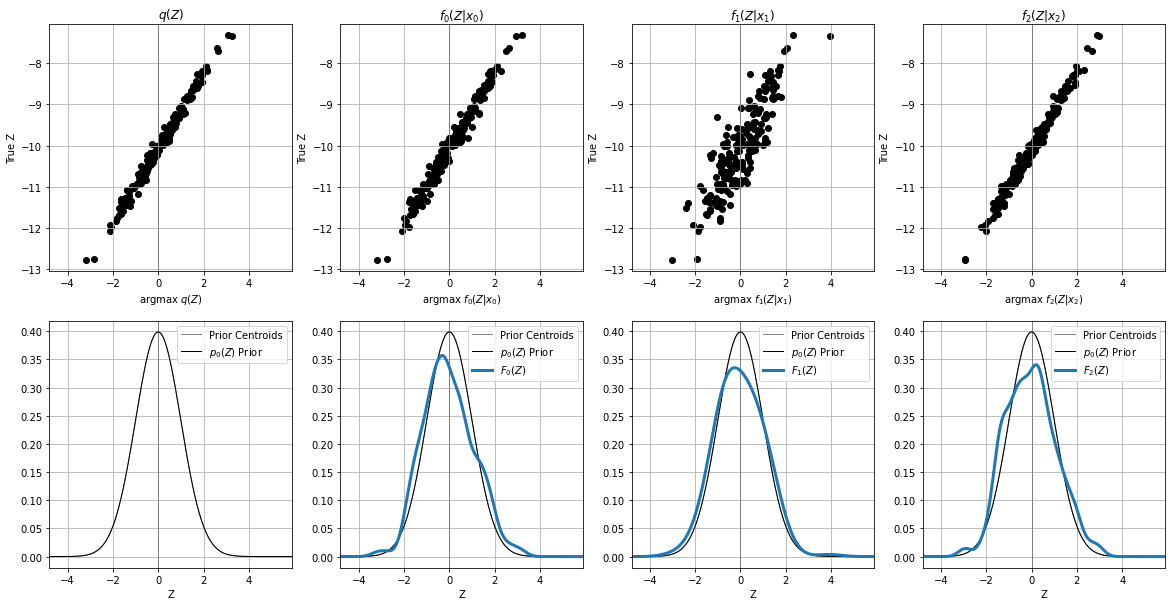

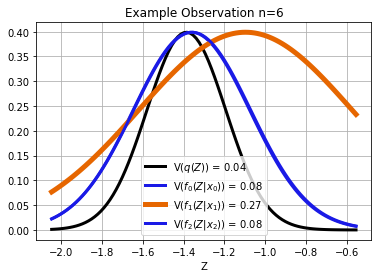

In [10]:
# Move the true Latent To CPU
true_latent = zlatent.to("cpu").numpy()

# Get fit results
recognition_distributions, prior_distribution = get_results(rpm, observations)
plot_num = len(recognition_distributions.keys())


# Figure Size
heigh = 2
width = plot_num
plt.figure(figsize=(width * 5, heigh * 5))

# Loop over distribution
for ii, key in enumerate(recognition_distributions.keys()):
    
    # Recognition Results
    res = recognition_distributions[key]
    mean = res['mean'].numpy()
    vari = res['variance']
    name = res['name']
    mixture = res['mixture_pdf']
    zrange = res['range']
    
    # Ztrue Vs Zfit
    plt.subplot(heigh, width, ii + 1)
    plt.scatter(mean, true_latent, c='k')
    
    # Plot Prior centroids as vertical line
    for pmean in prior_distribution['mean'].numpy():
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
    
    # Labels
    plt.ylabel('True Z')
    plt.xlabel('argmax ' + name)
    plt.xlim([zrange.min(), zrange.max()])
    plt.title(name)
    plt.grid()
    
    # Prior and Mixture pdfs
    plt.subplot(heigh, width, ii + 1 + width)
    
    # Plot Prior centroids as vertical line
    for pmean, ppdf in zip(prior_distribution['mean'].numpy(), prior_distribution['prior_all'].transpose(-1, -2)):
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
        plt.plot(zrange, ppdf, lw =1, c='gray')
    plt.plot(zrange, prior_distribution['prior'], lw =1, c='k', label = r'$p_0(Z)$ Prior')
    if mixture is not None:
        plt.plot(zrange, mixture, label= r'$F_' + name[-3] + '(Z)$', lw=3)
        
    # Labels
    plt.xlim([zrange.min(), zrange.max()])    
    plt.xlabel('Z')
    plt.grid()
    plt.legend()
    
example_observation = 6

means = [
    recognition_distributions[key]['mean'][example_observation]
    for key in recognition_distributions.keys()
]

vari = [
    recognition_distributions[key]['variance']
    for key in recognition_distributions.keys()
]


z0 = torch.mean(torch.tensor(means))
zdelta = 20 * torch.tensor(vari).min()
zrange = torch.linspace(z0 - zdelta, z0 + zdelta, 100)

densities = [
    gdensity1D(imean, ivari)(zrange).squeeze()
    for imean, ivari in zip(means, vari)
]

titles = [
    recognition_distributions[key]['name'] 
    for key in recognition_distributions.keys()
]

colors = [ [0.1, 0.1, 0.9] for _ in densities]
colors[0] = [0.0, 0.0, 0.0]
colors[2] = [0.9, 0.4, 0.0]

linewidths = [ 3 for _ in densities]
linewidths[2] = 5


plt.figure()
for ii, density in enumerate(densities):

    plt.plot(
        zrange, 
        density,
        label = 'V(' + titles[ii] + ') = ' + str(np.round(vari[ii], 2).numpy().squeeze()),
        c = colors[ii],
        lw = linewidths[ii],
    )

plt.title('Example Observation n=' + str(example_observation))
plt.xlabel('Z')
plt.grid()
plt.legend()


**Figure 2**:  **Top** Predicted Vs Fitted Latent. **Middle** Probability Density Functions of the prior and the Recognition Factors Mixture $\mathsf{F_j}$. **Bottom** Typical posterior distribution for one observation.
    
**Preliminary Conclusion**: brigging a third observation factor allows to disambiguate the fit. Two out of three factors align in latent space, which helps infering that residual variance on the remaining factor is private.   

### 2.3 Mixture Prior, 3 Factors, Unimodal Model: Impossible (or at least difficult).

We keep the same set-up except for $U = 2$ but we keep fitting with a normal prior.


In [11]:
# Random seeds
torch.manual_seed(1) 
np.random.seed(1)    

# Fit params
num_factors =  3
dim_latent_true = 1
dim_observations = 10
num_observations = 200
variance_scales = [1, 10, 1]

observations, zlatent = generate_1D_mixture_factor_analysis(
    num_observations, 
    dim_observations,
    num_factors,
    cluster_num = 2,
    cluster_scattering = 10,
    amplitude_cluster = 8,  
    variance_scales = variance_scales,
)

factors_params = {
    'dim_hidden': [[], [], []],
    'non_linearity': [torch.nn.Identity(), torch.nn.Identity(), torch.nn.Identity()],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
}

prior_params = {
    'num_centroids': 1,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=0.0, weight_decay=0.0),
}

fit_params = {
    'num_epoch': 20000,
    'dim_latent': 1,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

rpm.fit(observations)

RPM on GPU Observations on cuda:0
Epoch 2000/20000 Loss: 1.482266e+01
Epoch 4000/20000 Loss: 1.472488e+01
Epoch 6000/20000 Loss: 1.467032e+01
Epoch 8000/20000 Loss: 1.463004e+01
Epoch 10000/20000 Loss: 1.459933e+01
Epoch 12000/20000 Loss: 1.457527e+01
Epoch 14000/20000 Loss: 1.455448e+01
Epoch 16000/20000 Loss: 1.454254e+01
Epoch 18000/20000 Loss: 1.453390e+01
Epoch 20000/20000 Loss: 1.452798e+01


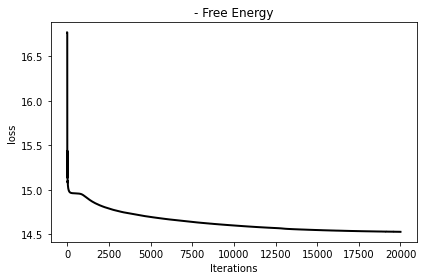

In [12]:
plot_loss(rpm)

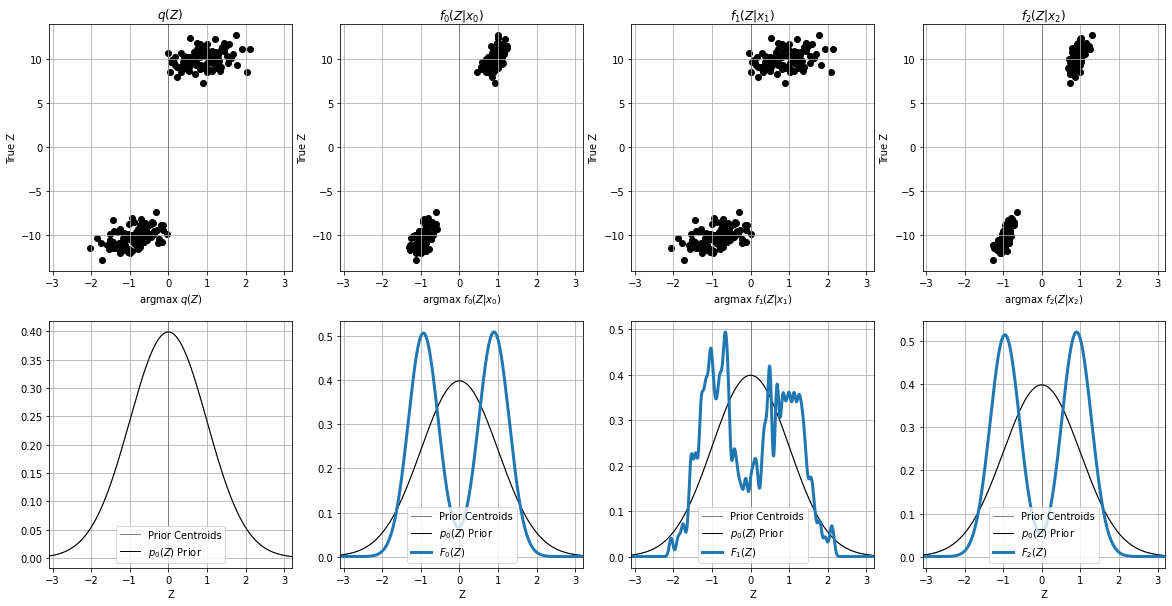

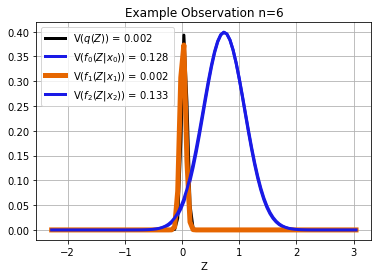

In [13]:
# Move the true Latent To CPU
true_latent = zlatent.to("cpu").numpy()

# Get fit results
recognition_distributions, prior_distribution = get_results(rpm, observations)
plot_num = len(recognition_distributions.keys())


# Figure Size
heigh = 2
width = plot_num
plt.figure(figsize=(width * 5, heigh * 5))

# Loop over distribution
for ii, key in enumerate(recognition_distributions.keys()):
    
    # Recognition Results
    res = recognition_distributions[key]
    mean = res['mean'].numpy()
    vari = res['variance']
    name = res['name']
    mixture = res['mixture_pdf']
    zrange = res['range']
    
    # Ztrue Vs Zfit
    plt.subplot(heigh, width, ii + 1)
    plt.scatter(mean, true_latent, c='k')
    
    # Plot Prior centroids as vertical line
    for pmean in prior_distribution['mean'].numpy():
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
    
    # Labels
    plt.ylabel('True Z')
    plt.xlabel('argmax ' + name)
    plt.xlim([zrange.min(), zrange.max()])
    plt.title(name)
    plt.grid()
    
    # Prior and Mixture pdfs
    plt.subplot(heigh, width, ii + 1 + width)
    
    # Plot Prior centroids as vertical line
    for pmean, ppdf in zip(prior_distribution['mean'].numpy(), prior_distribution['prior_all'].transpose(-1, -2)):
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
        plt.plot(zrange, ppdf, lw =1, c='gray')
    plt.plot(zrange, prior_distribution['prior'], lw =1, c='k', label = r'$p_0(Z)$ Prior')
    if mixture is not None:
        plt.plot(zrange, mixture, label= r'$F_' + name[-3] + '(Z)$', lw=3)
        
    # Labels
    plt.xlim([zrange.min(), zrange.max()])    
    plt.xlabel('Z')
    plt.grid()
    plt.legend()
    
example_observation = 6

means = [
    recognition_distributions[key]['mean'][example_observation]
    for key in recognition_distributions.keys()
]

vari = [
    recognition_distributions[key]['variance']
    for key in recognition_distributions.keys()
]


z0 = torch.mean(torch.tensor(means))
zdelta = 20 * torch.tensor(vari).max()
zrange = torch.linspace(z0 - zdelta, z0 + zdelta, 100)

densities = [
    gdensity1D(imean, ivari)(zrange).squeeze()
    for imean, ivari in zip(means, vari)
]

titles = [
    recognition_distributions[key]['name'] 
    for key in recognition_distributions.keys()
]

colors = [ [0.1, 0.1, 0.9] for _ in densities]
colors[0] = [0.0, 0.0, 0.0]
colors[2] = [0.9, 0.4, 0.0]

linewidths = [ 3 for _ in densities]
linewidths[2] = 5


plt.figure()
for ii, density in enumerate(densities):

    plt.plot(
        zrange, 
        density,
        label = 'V(' + titles[ii] + ') = ' + str(np.round(vari[ii], 3).numpy().squeeze()),
        c = colors[ii],
        lw = linewidths[ii],
    )

plt.title('Example Observation n=' + str(example_observation))
plt.xlabel('Z')
plt.grid()
plt.legend()

**Figure 3**:  **Top** Predicted Vs Fitted Latent. **Middle** Probability Density Functions of the prior and the Recognition Factors Mixture $\mathsf{F_j}$. **Bottom** Typical posterior distribution for one observation.
    
**Preliminary Conclusion**: the covariance of the noisy factor is greatly underestimated. One possible explanation (actually I don't have any other) is that it is due to the mismatch between the prior and the factors mixture. The latter is clearly multimodal while the model prior is set to be gaussians. 

**Note** here we used a linear recognition model. RPM might have been able to wrap embedding space if we used a powerful non linear recognition, but I think this might have led to many optimization issues like local optimum. 

### 2.4 Mixture Prior, 3 Factors, Mixture Prior Model: Possible.

Finally, we set $U = 2$ and fit with a mixture prior.

In [15]:
# Random seeds
torch.manual_seed(1) 
np.random.seed(1)    

# Fit params
num_factors =  3
dim_latent_true = 1
dim_observations = 10
num_observations = 200
variance_scales = [1, 10, 1]

observations, zlatent = generate_1D_mixture_factor_analysis(
    num_observations, 
    dim_observations,
    num_factors,
    cluster_num = 2,
    cluster_scattering = 10,
    amplitude_cluster = 8,  
    variance_scales = variance_scales,
)

factors_params = {
    'dim_hidden': [[], [], []],
    'non_linearity': [torch.nn.Identity(), torch.nn.Identity(), torch.nn.Identity()],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
}

prior_params = {
    'num_centroids': 2,
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
}


variational_params = {
    'dim_hidden': [],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-2, weight_decay=0.0),
    'non_linearity':torch.nn.Identity(),
}



fit_params = {
    'num_epoch': 20000,
    'dim_latent': 1,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

rpm.fit(observations)

RPM on GPU Observations on cuda:0
Pre-Training Completed. Stop Criterion Reached.
Epoch 2000/20000 Loss: 1.240897e+01
Epoch 4000/20000 Loss: 1.237434e+01
Epoch 6000/20000 Loss: 1.238860e+01
Epoch 8000/20000 Loss: 1.235242e+01
Epoch 10000/20000 Loss: 1.234783e+01
Epoch 12000/20000 Loss: 1.242093e+01
Epoch 14000/20000 Loss: 1.234822e+01
Epoch 16000/20000 Loss: 1.235614e+01
Epoch 18000/20000 Loss: 1.233701e+01
Epoch 20000/20000 Loss: 1.234016e+01


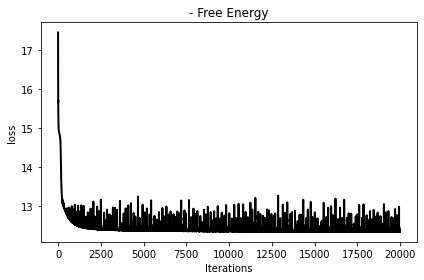

In [16]:
plot_loss(rpm)

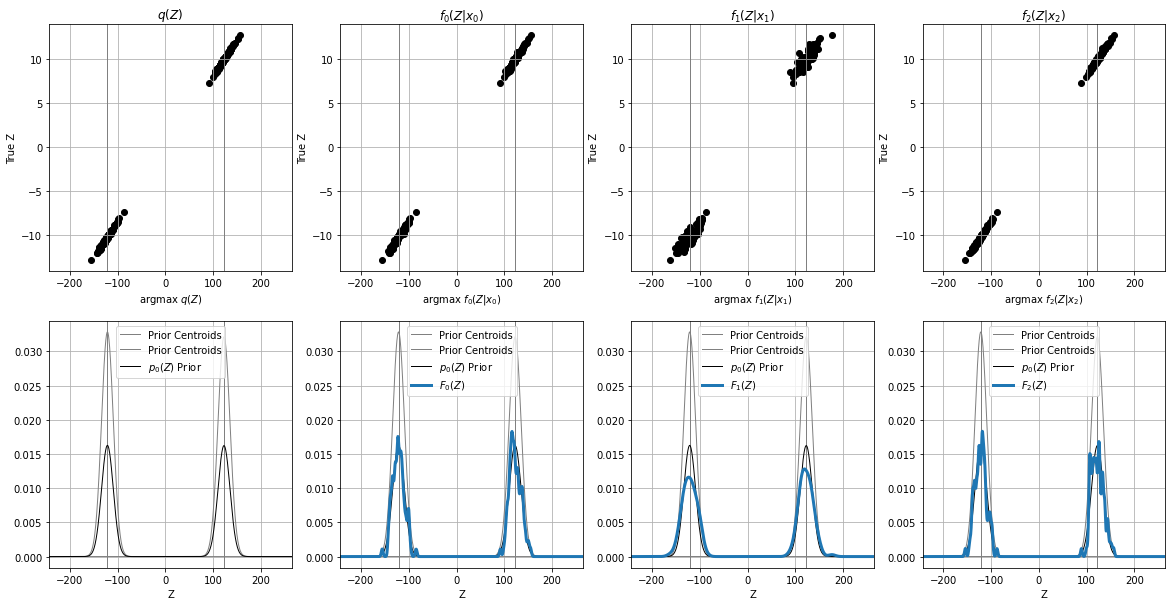

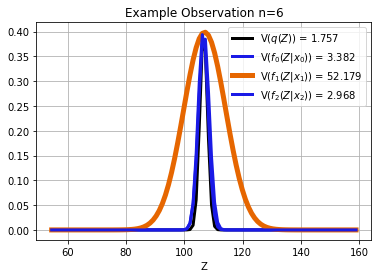

In [17]:
# Move the true Latent To CPU
true_latent = zlatent.to("cpu").numpy()

# Get fit results
recognition_distributions, prior_distribution = get_results(rpm, observations)
plot_num = len(recognition_distributions.keys())


# Figure Size
heigh = 2
width = plot_num
plt.figure(figsize=(width * 5, heigh * 5))

# Loop over distribution
for ii, key in enumerate(recognition_distributions.keys()):
    
    # Recognition Results
    res = recognition_distributions[key]
    mean = res['mean'].numpy()
    vari = res['variance']
    name = res['name']
    mixture = res['mixture_pdf']
    zrange = res['range']
    
    # Ztrue Vs Zfit
    plt.subplot(heigh, width, ii + 1)
    plt.scatter(mean, true_latent, c='k')
    
    # Plot Prior centroids as vertical line
    for pmean in prior_distribution['mean'].numpy():
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
    
    # Labels
    plt.ylabel('True Z')
    plt.xlabel('argmax ' + name)
    plt.xlim([zrange.min(), zrange.max()])
    plt.title(name)
    plt.grid()
    
    # Prior and Mixture pdfs
    plt.subplot(heigh, width, ii + 1 + width)
    
    # Plot Prior centroids as vertical line
    for pmean, ppdf in zip(prior_distribution['mean'].numpy(), prior_distribution['prior_all'].transpose(-1, -2)):
        plt.axvline(x=pmean, label='Prior Centroids', lw=1, c='gray')
        plt.plot(zrange, ppdf, lw =1, c='gray')
    plt.plot(zrange, prior_distribution['prior'], lw =1, c='k', label = r'$p_0(Z)$ Prior')
    if mixture is not None:
        plt.plot(zrange, mixture, label= r'$F_' + name[-3] + '(Z)$', lw=3)
        
    # Labels
    plt.xlim([zrange.min(), zrange.max()])    
    plt.xlabel('Z')
    plt.grid()
    plt.legend()
    
example_observation = 6

means = [
    recognition_distributions[key]['mean'][example_observation]
    for key in recognition_distributions.keys()
]

vari = [
    recognition_distributions[key]['variance']
    for key in recognition_distributions.keys()
]


z0 = torch.mean(torch.tensor(means))
zdelta = 1 * torch.tensor(vari).max()
zrange = torch.linspace(z0 - zdelta, z0 + zdelta, 100)

densities = [
    gdensity1D(imean, ivari)(zrange).squeeze()
    for imean, ivari in zip(means, vari)
]

titles = [
    recognition_distributions[key]['name'] 
    for key in recognition_distributions.keys()
]

colors = [ [0.1, 0.1, 0.9] for _ in densities]
colors[0] = [0.0, 0.0, 0.0]
colors[2] = [0.9, 0.4, 0.0]

linewidths = [ 3 for _ in densities]
linewidths[2] = 5


plt.figure()
for ii, density in enumerate(densities):

    plt.plot(
        zrange, 
        density,
        label = 'V(' + titles[ii] + ') = ' + str(np.round(vari[ii], 3).numpy().squeeze()),
        c = colors[ii],
        lw = linewidths[ii],
    )

plt.title('Example Observation n=' + str(example_observation))
plt.xlabel('Z')
plt.grid()
plt.legend()


**Figure 4**:  **Top** Predicted Vs Fitted Latent. **Middle** Probability Density Functions of the prior and the Recognition Factors Mixture $\mathsf{F_j}$. **Bottom** Typical posterior distribution for one observation.
    
**Preliminary Conclusion**: The variational bound used to fit the prior seems to be tight enough which allows a meaningful fit of the covariances. 